# to do:

1. Put rvir inside the first functrions in the gas profile, is really anoying to change rvir by hand everytime!

$\rho_g(r) = \rho_{g0} e ^{-27b/2}\left(1 + \dfrac{r}{r_s}\right)^{27b/(2r/r_s)}$ (1)


$\rho_{g0} = \dfrac{f_{gas}\Omega_b \rho_{c0}\delta_c}{\Omega_0} e ^{27b/2} \left[ ln(1+c) - \dfrac{c}{1+c} \right] \times \left[ \int_{0}^{c} x^2 (1+x)^{27b/2x} dx\right]^{-1} $

$\rho_{g}(r) = \dfrac{\rho_{g0 A(b)}}{[1+(r/r_{c,eff})^2]^{3\beta_{eff}/2}}$ (2)


In [1]:
%pylab inline
from scipy.integrate import quad
import os
from scipy.special import gamma
from scipy import integrate
from astropy import units as u

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Computation of the gas density profiles. This computations is divided in two main approaches.
In the first one we compute $\rho_g(r)$ folowing Makino et al 98. In that work they derive 
An expresion for the gas density from a NFW profile Eq.1. They also found function that fits 
very well this profile eq.2

In order to compute this profiles we choose all in units of grams and cm.

$z = 0$

$b = 0.7$

$c = 3.75$

$f_{gas} = 1$

$\Omega_0 = 0.32$

$\Omega_b = 0.04967$

$G = 6.67E-8$ [$cm^3/(gs^2)$]

$H_0 = 2.19E-18$ [1/s]

$r_{vir} = 118 kpc$

$\beta = 0.9b$


$\delta_c = \dfrac{200}{3}(\dfrac{c^3}{(log(1+c) - c/(1+c))})$

In [2]:
b = 0.7
A = -0.178*b + 0.982
beta = 0.9*b
r_vir = 118 #kpc This comes from a Mass of 1E12 M_sun and at z=2
#r_vir = 1.67  # 1E8M_sun, z=6
H_0 = 70.0 # km/s.Mpc
def constants():
    b = 0.7
    A = -0.178*b + 0.982
    beta = 0.9*b
    r_vir = 118*u.kpc #kpc
    c = 3.75
    r_s = r_vir/c
    return b, A, c

##  Code to make the integral of $\rho_{g0}$

In [3]:
def H(z, Omega0, H_0):
    Lambda0 = 1. - Omega0
    return H_0*(Omega0*(1+z)**3 - (Omega0+Lambda0-1)*(1+z)**2 + Lambda0)**0.5

def Omega_z(z,Omega0, H_0):
    return Omega0 * (1+z)**3 * (H_0/H(z,Omega0, H_0))**2

def model(x):
    b = 0.7
    return x**2 * ( (1+x)**(27*b/(2.*x)) )


def integral(c):
    x = linspace(0, c, 100)
    integral_scipy,err = quad(model, 0, c)
    return integral_scipy

print "The value of integral at c = 3.75: ", integral(3.75)

def rho_g0(zform):
    b = 0.7
    f_gas = 1.
    Omega_m = 0.32
    Omega_b = 0.022/(0.67**2)
    H_0 = 2.19E-18 #1/s
    G = 6.67E-8 # 
    rho_c = 3*H_0**2 / (8.*np.pi*G)
    c = 3.75
    #zform = 6.
    d_c = 3000.0 * Omega_m * (1 + zform)**3
    #d_c = 200/3. * (c**3 / (log(1 + c) - c/(1+c)))
    return ( ( (f_gas * d_c * rho_c * Omega_b) / Omega_m ) * exp(27. * b / 2.) * (log(1+c) - c/(1+c)) )  /  integral(c)

rho_g0(2)

The value of integral at c = 3.75:  2419.94935626


1.3753680168150579e-25

In [4]:
rhog0 = rho_g0(6) # g/cm3
print rhog0

1.74722677692e-24


## Computing the density profiles (Eq.1 & Eq.2)

In [5]:
def rho_aprox(r, z):
    c = 3.75
    r_s = r_vir/c
    return A*rho_g0(z)/(1 + ((r/r_s)*(1/0.22))**2)**(3*beta/2.)

def rho(r, z):
    c = 3.75
    r_s = r_vir/c
    mp =  1.67262158E-24
    rrho = rho_g0(z) * e**(-27*b/2.) * (1 + (r/r_s))**(27*b/(2*r/r_s))
    nh = rrho / mp 
    return rrho, nh 
rho(0.1, 2)

(1.3549129270145991e-25, 0.081005347725729995)

#Mark's data

In [6]:
Mdensity = loadtxt("dim.out")

In [7]:
Rho, nh = rho(Mdensity[:,0], 2)
Rho_aprox = rho_aprox(Mdensity[:,0], 2)

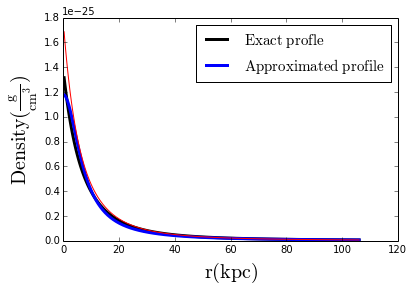

In [8]:
#plot(Mdensity[:,0], Mdensity[:,1], ls='--', lw=3, c='r')# Mark's Data
plot(Mdensity[:,0], Rho[:], c='k', lw=3, label="$\mathrm{Exact\ profle}$") # rescaling
plot(Mdensity[:,0], Rho_aprox[:], c='b', lw=3, label = "$\mathrm{Approximated\ profile}$")
plot(Mdensity[:,0], Mdensity[:,1], c='r')
legend(fontsize=15)
ylabel(r"$\mathrm{Density(\frac{g}{cm^{3}})}$", fontsize=20)
xlabel(r"$\mathrm{r(kpc)}$", fontsize=20)
savefig("gasprofile.png", bbox_inches='tight')

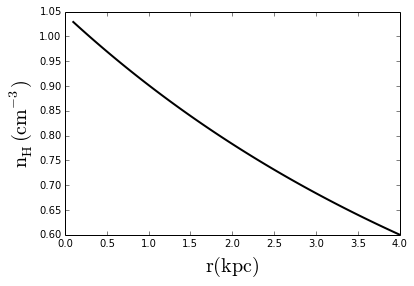

In [9]:
# Gas density profile in numbers of hydrogen atoms
N = 100
R = linspace(0.1, 4, N)
Rhoo, nh= rho(R, 6)
nh = nh
plot(R, nh, c='k', lw=2, label="Exact profle") # rescaling
ylabel(r"$\mathrm{n_H(cm^{-3}})}$", fontsize=20)
xlabel("$\mathrm{r(kpc)}$", fontsize=20)
savefig("nhvsr.png", bbox_inches='tight')

# Neutral Hydrogen density

In [10]:
def LamdaT(T): # cm3/s Equation A6, Rahmati et al 2013
    return 1.17E-10 * T**(0.5) * exp(-157809/T) / ( 1 + sqrt(T/10**5))

def alphaA(T): # cm3 / s Equation A3
    l = 315614/T
    return 1.269E-13 * l**(1.503) / ( 1 + (l/0.522)**(0.47) )**1.923 

def Gammaphot(GammaUVB, nh, NHSSH):
    Gammap =  GammaUVB * ( 0.98 *  (  1 + ( nh  / NHSSH )**(1.64) )**(-2.28) + 0.22 * ( 1 + nh  / NSSH)**(-0.84) )
    return Gammap

def ABC(T, G, nh, NSSH):
    a_A = alphaA(T)
    LT = LamdaT(T)
    GPhot = Gammaphot(G, nh, NSSH)
    A = a_A + LT
    B = 2*a_A + GPhot / nh + LT
    C = a_A
    return A, B, C

def Eta(A, B, C):
    eta = ( B - sqrt(B**2 - 4*A*C) ) / (2*A)
    return eta 

def tvir(M, z):
    T = 2554 * ( M / 1E6)**(2/3.) * ( (1 + z) / 31.0 )
    return T

In [11]:
z = 6
M = 1E8
T = tvir(M, z)
NSSH = 4.0E-3 # See table 2 of Rahmati et al 2013
GUVB = 4.5E-13 # See table 2 of Rahmati et al 2013

print " ---------- Parameters -----------"
print "z = ", z
print "Halo mass = ", M
print "NSSh = ", NSSH
print "Gamma_UVB = ", GUVB
print "----------------------------------"

 ---------- Parameters -----------
z =  6
Halo mass =  100000000.0
NSSh =  0.004
Gamma_UVB =  4.5e-13
----------------------------------


In [12]:
A = zeros(N)
B = zeros(N)
C = zeros(N)
E = zeros(N)
for i in range(N):
    A[i], B[i], C[i] = ABC(T, GUVB, nh[i], NSSH )
    E[i] = Eta(A[i], B[i], C[i])

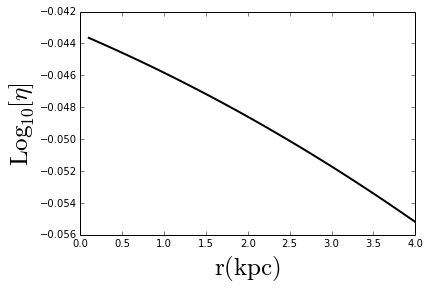

In [13]:
plot(R, log10(E), c='k', lw=2)
xlabel("$\mathrm{r(kpc)}$", fontsize=25)
ylabel("$\mathrm{Log_{10}[\eta]}$", fontsize=25)
savefig("etavsr", bbox_inches='tight')

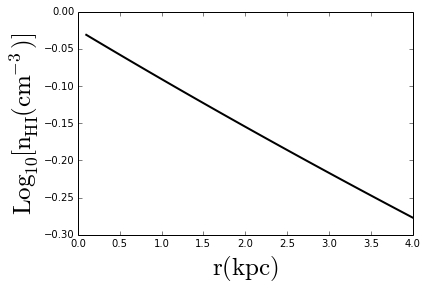

In [14]:
plot(R, log10(E*nh), c='k', lw=2)
xlabel("$\mathrm{r(kpc)}$", fontsize=25)
ylabel("$\mathrm{Log_{10}[n_{HI}(cm^{-3}})]$", fontsize=25)
savefig("nhivsr", bbox_inches='tight')

# Column Density Derivation

Column density for a given impact parameter $b$ and a given halo mass $M_h$:
$N_HI(b, M_H) = \int \limits_b^{\infty} \rho_{g}(r) =  \int \limits_b^{\infty} \dfrac{\rho_{g0 A(b)}}{[1+(r/r_{c,eff})^2]^{3\beta_{eff}/2}} = \rho_{g0} A(b) \dfrac{\sqrt{\pi} (\dfrac{1}{r_c(M_h)^2})^{-3\beta(M_h) /2} (b^2 + r_c(M_h)^2)^{1/2 - 2\beta(M_h)/2} \Gamma(-1/2 + 3\beta/2) }{2 \Gamma(\dfrac{3\beta(M_h)}{2})}  $ 

$b$ impact parameter


Average column density 

$ <N_H>  =  4 \int \limits_0^{0.5} dx \int \limits_0^{0.5} dy \int \limits_{M_{min}}^{M_{max}} N_{HI}(b, M_H) \xi(M_H) dM_H  $ 

In [219]:
def stmf(z, minm, maxm, nm):
    os.system("./stmf/stmf %d %d %d %d"%(z,minm, maxm,nm))
    stmf_data = loadtxt("stmf_LF.dat", skiprows=1)
    M2 = stmf_data[:,0]
    mdndm2 = stmf_data[:,1]
    cum_nh = stmf_data[:,2]
    return M2, mdndm2

In [220]:
def rvir(Mass, z): # THIS MASS IS IN Msun
    os.system("./rvirmod/a.out %d %d > rvir.txt"%(Mass, z))
    data = loadtxt("rvir.txt")
    rvir = data[0]
    return rvir

In [223]:
def nh(M, x, y):
    z = 6
    minm = M
    maxm = M
    nm = 2
    b, A, c = constants()
    M1, mdndm = stmf(z, minm, maxm, nm)
    beta = 0.9*b
    rvir1 = rvir(M, z)
    r_s = rvir1 / c 
    NH = (sqrt(pi)*(1/r_s**2)**(-3*beta/2.) * ((x**2  + y**2)+ r_s**2)**(1/2. - 3*beta/2.) * gamma(-0.5 + 3*beta/2.) )/(2*gamma(3*beta/2.))
    #print M1, beta, rvir1, r_s, NH
    return 4*NH*mdndm/M1

In order to compute the integral of the average column density we first make the integral over the mass
using the trapezoid method.

This is: 

$\int \limits_{M_{HMin}}^{M_{HMax}} N_H(b, M_H)\xi(M_H)dM_H =  (M_{HMax} - M_{HMin}) \left[ \dfrac{N_H(b, M_{Hmax}) \xi(M_{HMax}) + N_H(b, M_{HMin}\xi(M_{Hmin}))}{2}\right]$

with $M_{HMax} = 10^{12} M_{\odot}$ and $M_{HMin} = 10^4 M_{\odot}$

$\int \limits_{M_{HMin}}^{M_{HMax}} N_H(b, M_H)\xi(M_H)dM_H = 10^{12} M_{\odot}  \dfrac{\rho_{g0} A(b) \sqrt{\pi} \Gamma(-\dfrac{1}{2} + \dfrac{3\beta}{2})}{4\Gamma{\dfrac{3\beta}{2}}}\left[ \left( \dfrac{1}{r_c(M_{HMin})^2} \right)^{-3\beta/2} (b^2 + r_c(M_{Hmin})^2)^{1/2 - 3\beta/2} \xi(M_{Hmax})+  \left( \dfrac{1}{r_c(M_{HMax})^2} \right)^{-3\beta/2} (b^2 + r_c(M_{Hmax})^2)^{1/2 - 3\beta/2}\xi(M_{Hmin}) \right] $

In [224]:
# Run this before compute the avergae column density
M, mdnm = stmf(6, 4, 12, 1000)
print len(M)
Rvir = zeros(999)
for i in range(999):
    Rvir[i] = rvir(M[i], 6)
print min(M)

999
10000.0


In [225]:
def hm(x, y):
    beta = 0.7 * 0.9
    factor = sqrt(pi)*gamma(-0.5 + 3*beta/2.0) / (2*gamma(3*beta/2.))
    HN = zeros(1000)
    for i in range (998):
        xi_min = mdnm[i]/M[i]
        xi_max = mdnm[i+1]/M[i+1]
        DM = M[i+1] - M[i]
        rs_min = Rvir[i] / 3.75 
        rs_max = Rvir[i+1] / 3.75
        #print xi_min, xi_max, DM, rs_min, rs_max
        HN[i] = 0.5 * abs(DM) * factor * ( (1 / rs_min**2)**(-3*beta/2.0) * ((x**2 + y**2) + rs_min**2)**(0.5 - 3*beta/2.0 )*xi_min +
                              (1/rs_max**2)**(-3*beta/2.0) * ((x**2+y**2) + rs_max**2)**(0.5 - 3*beta/2.)*xi_max )
        #print HN[i]
        
    return sum(HN)

In [226]:
hm(0.5, 0.5)

273.90990132276022

In [105]:
hm(0.5, 0.5)

273.90990132276022

In [230]:
def mass_convergence(Mmin):
    global M
    global mdnm
    M, mdnm = stmf(6, Mmin, 12, 1000)
    print min(M)
    Rvir = zeros(999)
    for i in range(999):
        Rvir[i] = rvir(M[i], 6)
    Test = hm(0.5, 0.5)
    #print Test
    NH = integrate.dblquad(hm,0, 0.5, lambda x:0, lambda x:0.5, epsabs=0.001, epsrel=0.001)
    #print NH
    rhog0 = rho_g0(6)
    b = 0.7
    A = -0.178*b + 0.982
    NHmean = NH[0]*rhog0*A*4
    mp =  1.67262158E-24
    nhmean = NHmean / mp
    return NHmean, NH, nhmean

In [18]:
def check(M_min):
    MM, mdnm2 = stmf(6, M_min, 12, 1000)
    y = mdnm2
    I = zeros(1000)
    for i in range(len(MM)-1):
        y = mdnm2[i] 
        dx = MM[i+1] - MM[i]
        I[i] = abs(dx * y)
    return sum(I)

In [19]:
MM = linspace(2, 14, 13)
mdnmM = zeros(13)
for i in range(13):
    mdnmM[i] = check(MM[i])

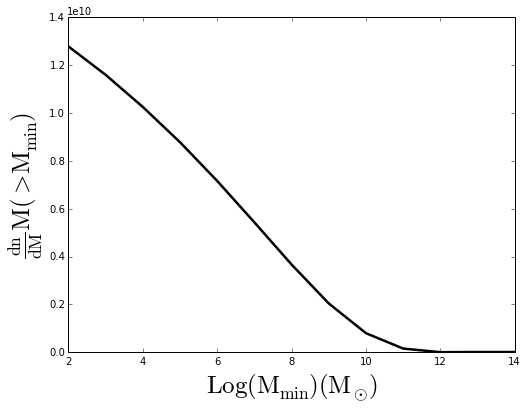

In [23]:
MD = zeros(13)
for i in range(13):
    MD[i] = sum(mdnmM[i:]) 
#plot(MM, mdnmM)
figure(figsize=(8, 6))
plot(MM, mdnmM, c='k', lw=2.5)
xlabel("$\mathrm{Log(M_{min}) (M_{\odot})}$", fontsize=25)
ylabel(r"$\mathrm{\frac{dn}{dM} M(>M_{min})}$", fontsize=25)
savefig("cumulativehm.png")